# GCN implementation from scratch

We are now going to build off the previous part to create a fully functional GCN from scratch using only Python and its library Numpy. Much credit to Thomas Kipf and team as well as Tobias Skovgaard for his excellent introduction into GCNs. Contrary to Kipf's implementation, I do not use Kipf's recommended symmetric normalization D^-0.5 * A * D^-0.5, but use only the inverse of the degree matrix D^-1 * A. This still produces excellent results. A next implementation will use the symmetric normalization. 

I drew much of the starter code for the node representations (part 1) from the following blogpost:
- [How to do Deep Learning on Graphs with Graph Convolutional Networks](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780)

For part 2, I draw from the ideas in Kipf's original paper on GCNs:
- [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)

Many thanks for [octavian.ai](https://octavian.ai) for providing their awesome course on graph ML. Also, many thanks to the [deeplearning.ai](https://deeplearning.ai) team for their excellent deep learning courses. If you have taken any of their courses before, you may find the structure of my code a little too familiar :-D

The code is divided in two parts. First we build an untrained GCN to understand some of the main ideas behind GCNs. Then we build and train a new GCN for node-classification. The data used is the Zachary Karate Club. We will try to classify nodes based on only two known labels - the club trainer and the administrator. 

## Setting up the model inputs

Here we set up the inputs for the GCN-model. The following inputs are needed:
- Adjacency matrix
- Feature matrix (or identity matrix for featureless nodes)

Then we need to do the following preprocessing steps:
- Add self-loops to the adjacency matrix (a_hat)
- Create the degree matrix based on a_hat

In [0]:
import numpy as np
from networkx import networkx, karate_club_graph, to_numpy_matrix
zkc = karate_club_graph()
order = sorted(list(zkc.nodes()))
# Adjacency matrix
A = to_numpy_matrix(zkc, nodelist=order)
# Identity matrix
I = np.eye(zkc.number_of_nodes())
# Adding self loops to consider nodes' own features.
A_hat = A + I
# Degree Matrix derived from A_hat
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

## Some Utils

First we define some functions needed for the forward and backward propagation.

In [0]:
def relu(Z):
  return np.maximum(Z, 0)

def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def relu_backward(Z):
  dZ = np.array(Z, copy=True) # just converting dz to a correct object.
  
  # When z <= 0, you should set dz to 0 as well. 
  dZ[Z <= 0] = 0
  
  assert (dZ.shape == Z.shape)
  
  return dZ

# Part 1: Building an untrained GCN for comparing node representations

Here we build a randomly initialized GCN to see how they can create node representations that separate nodes into different communities. We use these node representations to make some classifications using the cosine similarity. They could be used however as node-embeddings for downstream ML-tasks.

In [0]:
def gcn_layer(A_hat, D_hat, X, W, activation):
  if activation == 'sigmoid':
    return sigmoid(D_hat**-1 * A_hat * X * W)
  if activation == 'relu':
    return relu(D_hat**-1 * A_hat * X * W)

## Weight initialization

Here we initalize weights randomly. Run it a few times and be sure to check the node representation below. You will see that even a randomly initiated GCN can do a great job at separating communities. Don't forget to remove the np.random.seed() to see different node representations!

In [0]:
# Seed for developing purposes. You can comment out this line to see how node representations can vary.
# Don't be tricked by the high precision! I have purposely chosen a seed that produces good results! 
np.random.seed(1)

# Initialize weights randomly
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))

# Change the second dimension to 1 to make a classification rather than create an embedding 
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

## 2-Layer GCN

Here we crate a 2-layer GCN and use the sigmoid function in both layers. Using the sigmoid instead of the relu function in the first hidden layer results in better node representations for our next experiment. We will soon be using the relu function in the final implementation. 

In [0]:
# here we could also use the relu function
H_1 = gcn_layer(A_hat, D_hat, I, W_1, 'sigmoid')

H_2 = gcn_layer(A_hat, D_hat, H_1, W_2, 'sigmoid')
output = H_2

## Node representations visualized

Here we plot the node_representations (H_2) with matplotlib. You can see that communities are often well separated, even without training any weights yet. The colors of the datapoints represent the real labels.

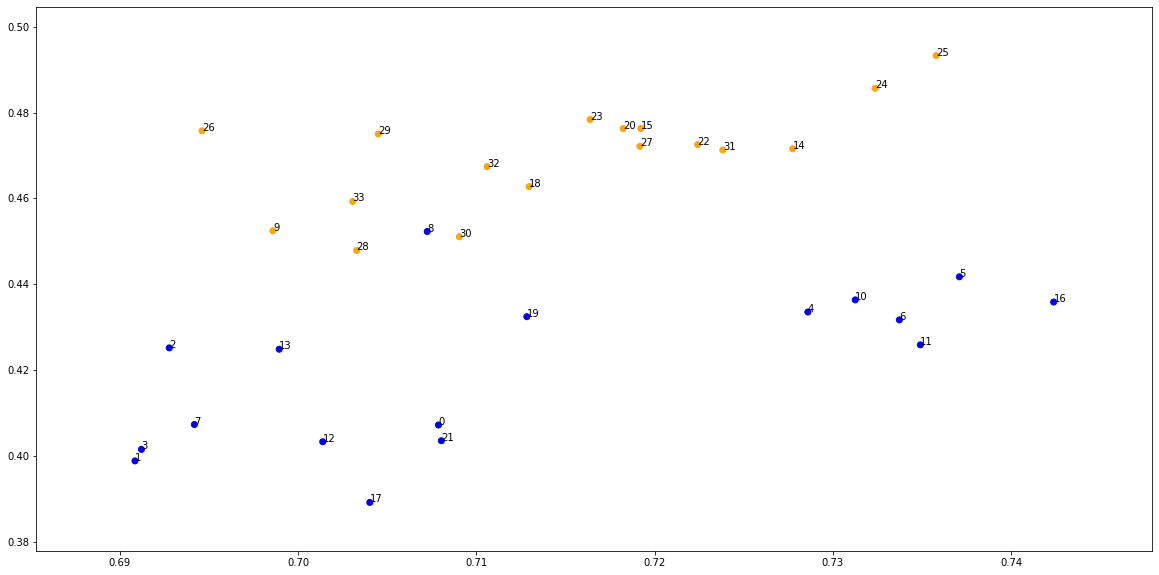

In [0]:
# Visualizing results
import matplotlib
import matplotlib.pyplot as plt

x = list(np.hsplit(output, 2)[0])
y = list(np.hsplit(output, 2)[1])
labels = []

colors = ['blue','orange']

for i in range(len(zkc.nodes())):
  if zkc.nodes()[i]['club'] == 'Mr. Hi':
    labels.append(0)
  else:
    labels.append(1)


index = range(len(x))
color_labels = ['blue' if l == 0 else 'orange' for l in labels]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x, y, color=color_labels)

for i, txt in enumerate(index):
    ax.annotate(txt, (x[i], y[i]))


## Making predictions 

We can use these node representations to make predictions. We compare the node to the trainer and administrator nodes with the cosine similarity function. The bigger the cosine similarity, the closer it resembles a particular node. 


In [0]:
# Make a prediction for a specific node

def predict(node_num, output):
  trainer = output[0]
  administrator = output[33]

  node = output[node_num]

  # We use the Cosine Similarity to classify nodes
  if node @ trainer.T / (np.linalg.norm(node) * np.linalg.norm(trainer)) > node @ administrator.T / (np.linalg.norm(node) * np.linalg.norm(administrator)):
    return 0
  else:
    return 1

In [0]:
def make_predictions(output):
  correct_predictions = 0

  predictions = []
  predictions.append(0)
  for i in range(1, len(output)-1):
    current_prediction = predict(i, output)
    predictions.append(current_prediction)

    if labels[i] == current_prediction:
      correct_predictions += 1
    else:
      print("Node " + str(i) + ": Predicted " + str(current_prediction) + ". Correct answer was " + str(labels[i]))

  predictions.append(1)
  print("Precision score: " + str(correct_predictions / 32))
  return predictions

predictions = make_predictions(output)

Node 2: Predicted 1. Correct answer was 0
Node 8: Predicted 1. Correct answer was 0
Precision score: 0.9375


## Graph with real labels

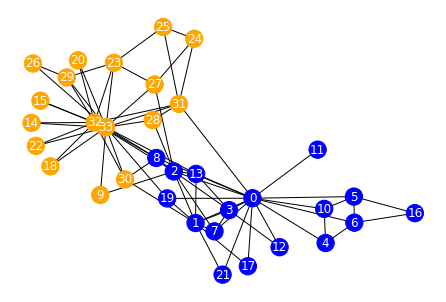

In [0]:
networkx.draw(zkc, with_labels=True, node_color=color_labels, font_color='white')

## Graph with predicted labels - Untrained GCN

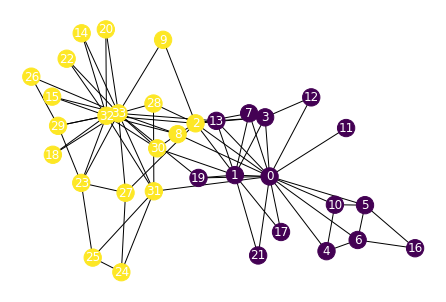

In [0]:
networkx.draw(zkc, with_labels=True, node_color=predictions, font_color='white')

# Part 2: Building and training a 2-layer GCN-Model

Now we will create a trainable GCN-Model. Contrary to the previous section, we will not use node representations, and therefore the Cosine Similarity function, to classify nodes, but will train it to make a prediction in the last layer. For this, we set the last dimension of the Weights in layer 2 to 1 and feed it to the sigmoid function. If this number is greater than 0.5, then it belongs to class 1, else class 0.

In [0]:
def initialize_parameters(num_nodes):
  W1 = np.random.normal(
    loc=0, scale=1, size=(num_nodes, 4))
  W2 = np.random.normal(
      loc=0, size=(W_1.shape[1], 1))
  
  parameters = {"W1": W1,
                "W2": W2}
    
  return parameters

def forward_propagation(A_hat, D_hat, X, parameters):
  W1 = parameters["W1"]
  W2 = parameters["W2"]

  Z1 = D_hat**-1 * A_hat * X * W1
  H1 = relu(Z1)
  Z2 = D_hat**-1 * A_hat * H1 * W2
  H2 = sigmoid(Z2)

  cache = {"Z1": Z1,
           "H1": H1,
           "Z2": Z2,
           "H2": H2}
  return H2, cache

## Computing cost

We compute the cost w.r.t the known labels. In the case of the Zachary Karate club, we know that node 0, the trainer, has a class of 0. Node 33, the administrator, has a class of 1.

In [0]:
# Compute cost for known labels

def compute_cost(H2, Y, parameters, known_labels):
  m = len(known_labels)
  H2 = H2[known_labels].T
  Y = Y[known_labels].T
  logprobs = np.multiply(Y,np.log(H2)) + np.multiply((1-Y),np.log(1-H2))
  cost = -1/m * np.sum(logprobs)
  cost = float(np.squeeze(cost))
  return cost

## Backpropagation

Below we build the back propagation functions. We update the weights on every iteration. 

In [0]:
def backward_propagation(parameters, cache, X, Y, D_hat, A_hat):
  m = X.shape[1]
  W1 = parameters["W1"]
  W2 = parameters["W2"]

  H1 = cache["H1"]
  H2 = cache["H2"]
  Z1 = cache["Z1"]
  Z2 = cache["Z2"]

  dZ2 = H2 - Y
  dW2 = 1/m * (D_hat**-1 * A_hat * H1).T @ dZ2 

  dZ1 = np.multiply(dZ2 @ W2.T, relu_backward(Z1)) 
  dW1 = 1/m * (D_hat**-1 * A_hat * X) @ dZ1

  grads = {"dW1": dW1,
           "dW2": dW2}
    
  return grads

def update_parameters(parameters, grads, learning_rate):
  W1 = parameters["W1"]
  W2 = parameters["W2"]

  dW1 = grads["dW1"]
  dW2 = grads["dW2"]

  W1 = W1 - learning_rate * dW1
  W2 = W2 - learning_rate * dW2

  parameters = {"W1": W1,
                "W2": W2}
    
  return parameters

## Bringing it all together

We define a model that integrates all the previous functions and trains the model. 

In [0]:
def train_model(A_hat, D_hat, X, Y, num_nodes, known_labels, learning_rate = 0.1, num_iterations = 5000, print_cost=False):
    
    # We use a seed to stabilize the results during development
    np.random.seed(2)
    
    costs = []
    # Initialize parameters
    parameters = initialize_parameters(num_nodes)
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "A_hat, D_hat, X, parameters". Outputs: "H2, cache".
        H2, cache = forward_propagation(A_hat, D_hat, X, parameters)
        
        # Cost function. Inputs: "H2, Y, parameters, known_labels". Outputs: "cost".
        cost = compute_cost(H2, Y, parameters, known_labels)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y, D_hat, A_hat". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y, D_hat, A_hat)
 
        # Gradient descent parameter update. Inputs: "parameters, grads, learning_rate". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 1000 training example
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return H2, parameters


# Training the model

We train the model and plot the cost. We can see that the cost starts to plateau around the 2,000th iteration.  

Cost after iteration 0: 0.6650999304009246
Cost after iteration 1000: 0.17250518378789945
Cost after iteration 2000: 0.027081516336789287
Cost after iteration 3000: 0.010963627134638566
Cost after iteration 4000: 0.006816810363715109


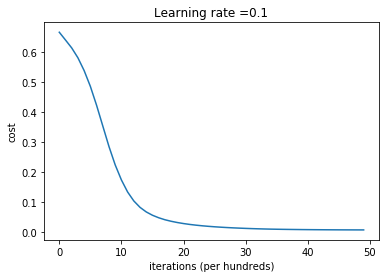

In [0]:
num_nodes = zkc.number_of_nodes()
known_labels = [0, 33]
Y = np.asmatrix(labels).reshape(-1,1)

H2, parameters = train_model(A_hat, D_hat, I, Y, num_nodes, known_labels, print_cost=True)

In [0]:
def predict(node_num, output):
  trainer = output[0]
  administrator = output[33]

  predictions = H2 > 0.5

  # Hard coding known labels (you can also predict these, but since they are known there is no need to do so)
  predictions[0] = 0
  predictions[33] = 1

  return int(np.squeeze(predictions[node_num].astype(int))) 

def accuracy_score(H2, Y):
  correct_predictions = 0

  predictions = []

  for i in range(0, len(output)):
    current_prediction = predict(i, output)
    predictions.append(current_prediction)

    if labels[i] == current_prediction:
      correct_predictions += 1
    else:
      print("Node " + str(i) + ": Predicted " + str(current_prediction) + ". Correct answer was " + str(labels[i]))
      # Changes color of false prediction. "2" means here "incorrect classification". Helps us visualize the result better
      predictions[i] = 2

  print("Precision score: " + str(correct_predictions / 34))
  return predictions

predictions = accuracy_score(H2, Y)

Node 8: Predicted 1. Correct answer was 0
Precision score: 0.9705882352941176


## Graph with predicted labels - Trained GCN

We can observe the graph and the predictions made. We can see that we made a false prediction on Node 8. This is certainly a difficult node to classify since it is placed just between both communities. Nevertheless, we have achieved a precision of about 97.1% - only missing one node! 

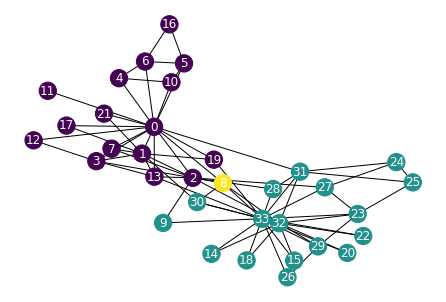

In [0]:
networkx.draw(zkc, with_labels=True, node_color=predictions, font_color='white', seed=100)